<a href="https://colab.research.google.com/github/rezjaq/SVIP/blob/main/Detection_Obejct_With_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang dibutuhkan
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [2]:
!pip install kaggle
# Upload kaggle.json ke colab dan set lingkungan variabel
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d mohamedgobara/26-class-object-detection-dataset
!unzip 26-class-object-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.9ad685958a62789c009e145b95c20fb5.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.ac144ec6c9246376d437f7bb116e7b7f.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.b923c2d5c3ff21e7c89f5e1af8df147c.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.c1c1e751997edc4f93c8228819ee4d9b.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.c9f5c9073b96bc00533b5eed84732662.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.cbcb390c28ccff14d3319e134de7add2.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.e5d470d3d89806960f99f226adfb33aa.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.f037177920fc67483d02505d6d3b0ca7.jpg  
  inflating: Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.fe97e03dc6ce989849a6cf6f34971d70.jpg  
  in

In [3]:
import os
import cv2
import numpy as np
import random

# Folder tempat gambar berada
image_folder = '/content/Senior-Design-VIAD-4/'

# Membaca gambar dan label secara acak, dengan batasan 1000 gambar
def load_images(image_folder, max_images=1000):
    images = []
    labels = []
    image_paths_labels = []

    # Membaca semua gambar dan label ke dalam list image_paths_labels
    class_names = os.listdir(image_folder)

    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                image_paths_labels.append((image_path, class_name))

    # Mengacak urutan gambar dan label
    random.shuffle(image_paths_labels)

    # Mengambil maksimal max_images gambar setelah diacak
    for image_path, class_name in image_paths_labels[:max_images]:
        print(f"Loading image: {image_path}")  # Cek path gambar
        img = cv2.imread(image_path)

        # Cek apakah gambar valid (tidak rusak)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue  # Lewati gambar yang gagal dimuat

        # Cek apakah gambar memiliki dimensi yang valid (misalnya tidak kosong)
        if img.shape[0] == 0 or img.shape[1] == 0:
            print(f"Image is empty: {image_path}")
            continue  # Lewati gambar yang tidak valid

        # Resize gambar dan normalisasi
        img = cv2.resize(img, (224, 224))  # Menyesuaikan ukuran gambar
        images.append(img)
        labels.append(class_name)

    return np.array(images), np.array(labels)

# Memanggil fungsi untuk mengambil gambar dan label
images, labels = load_images(image_folder, max_images=1000)

# Menampilkan jumlah gambar yang berhasil dimuat
print(f"Total images loaded: {len(images)}")


Loading image: /content/Senior-Design-VIAD-4/train/326513211_898847588209907_3594997865095589924_n_jpg.rf.8fda799b58b7d29bd17f645ae067ac1e.jpg
Loading image: /content/Senior-Design-VIAD-4/train/ratten-vertreiben-hausmittel-ohne-gift_jpg.rf.5caaf8c744aeae81840a715b149b8855.jpg
Loading image: /content/Senior-Design-VIAD-4/train/292c73578f9f5b28e8a3c265fdce140d6874afe6_jpg.rf.8913a55a4a2d37fcbc689460dbccfc23.jpg
Loading image: /content/Senior-Design-VIAD-4/train/115_jpg.rf.b09943040bdf109ebdb7260a9d09c3df.jpg
Loading image: /content/Senior-Design-VIAD-4/train/c6a079fccb9ca9a8_jpg.rf.7a310f6142f487e2a6c1e54b3981d1b5.jpg
Loading image: /content/Senior-Design-VIAD-4/train/traffic-light-160-_jpg.rf.98b5856ce3fd1fba704961293074f4d3.jpg
Loading image: /content/Senior-Design-VIAD-4/train/youtube-57_jpg.rf.03c3d6c3cb11c7f7cd689eb104a7b257.jpg
Loading image: /content/Senior-Design-VIAD-4/train/traffic-light-186-_jpg.rf.dde5408a983004e93ae57306cab40acd.jpg
Loading image: /content/Senior-Design-VIAD

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encoding label kategori dengan LabelEncoder
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)  # Mengubah label menjadi angka
    return encoded_labels, label_encoder

# Melakukan encoding pada label
encoded_labels, label_encoder = encode_labels(labels)

# Menampilkan contoh mapping label asli ke label yang di-encode
print("Label mapping:")
for original, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original}: {encoded}")

Label mapping:
test: 0
train: 1
valid: 2


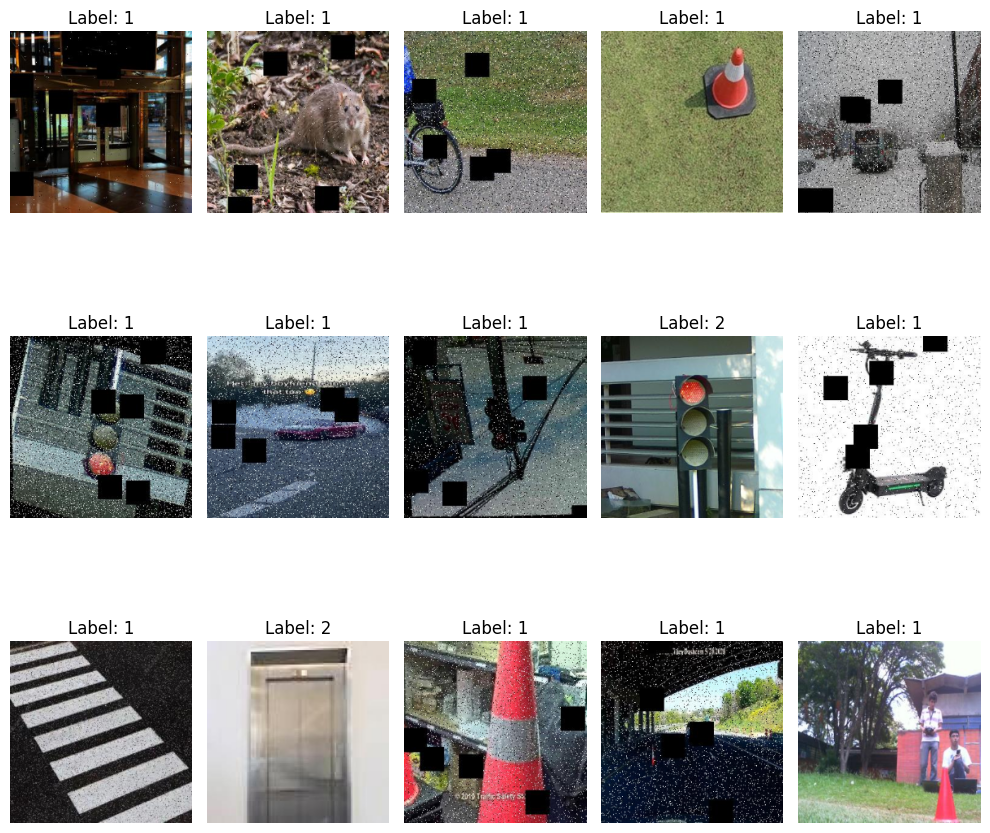

In [5]:
import matplotlib.pyplot as plt

# Menampilkan 15 gambar yang telah di-encode
def display_images(images, encoded_labels, num_images=15):
    plt.figure(figsize=(10, 10))

    # Loop untuk menampilkan gambar
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)  # 3 baris, 5 kolom untuk 15 gambar
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Mengubah BGR ke RGB
        plt.title(f"Label: {encoded_labels[i]}")  # Menampilkan label yang sudah di-encode
        plt.axis('off')  # Menghilangkan axis
    plt.tight_layout()
    plt.show()

# Menampilkan 15 gambar acak dan label yang sudah di-encode
display_images(images, encoded_labels, num_images=15)


In [6]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi data training dan test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Menampilkan ukuran dataset setelah pembagian
print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")

Training data: (800, 224, 224, 3), Test data: (200, 224, 224, 3)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membangun model CNN
def build_model(input_shape, num_classes):
    model = Sequential()

    # Layer Convolutional
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten dan Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout untuk mencegah overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Output layer sesuai jumlah kelas

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Membangun model dengan input shape (224, 224, 3) dan jumlah kelas berdasarkan label yang ada
model = build_model(input_shape=(224, 224, 3), num_classes=len(np.unique(encoded_labels)))

# Menampilkan summary model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Menyimpan model setelah training (optional)
model.save('model.h5')

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.6593 - loss: 95.3658 - val_accuracy: 0.7950 - val_loss: 0.5243
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8321 - loss: 0.4946 - val_accuracy: 0.8000 - val_loss: 0.5931
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8544 - loss: 0.3923 - val_accuracy: 0.8000 - val_loss: 1.0225
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8329 - loss: 0.5197 - val_accuracy: 0.8000 - val_loss: 0.5613
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8602 - loss: 0.3883 - val_accuracy: 0.8050 - val_loss: 0.6673
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8635 - loss: 0.3374 - val_accuracy: 0.8050 - val_loss: 0.5420
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8972 - loss: 0.2973 - val_accuracy: 0.7900 - val_loss: 0.7123
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.9148 - loss: 0.2377 - val_accuracy: 0.7750 - 

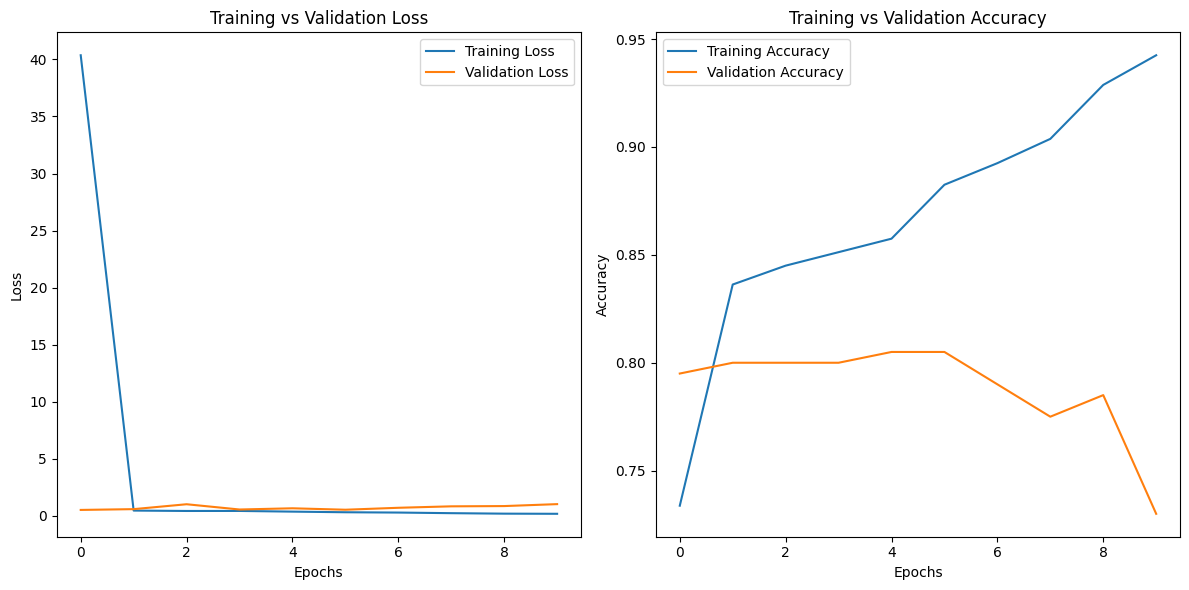

25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9190 - loss: 0.3066
Train Loss: 27.22 %
Train Accuracy: 91.75 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 851ms/step - accuracy: 0.7293 - loss: 0.9700
Test Loss: 103.22 %
Test Accuracy: 73.00 %


In [12]:
# Fungsi untuk memvisualisasikan history pelatihan dan evaluasi model
def plot_training_history(history, model, X_train, y_train, X_test, y_test):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    print(f"Train Loss: {train_loss * 100:.2f} %")
    print(f"Train Accuracy: {train_accuracy * 100:.2f} %")

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss * 100:.2f} %")
    print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

# Memanggil fungsi untuk memplot history pelatihan dan evaluasi model
plot_training_history(history, model, X_train, y_train, X_test, y_test)

In [ ]:
# Clone repository YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.66 MiB | 18.54 MiB/s, done.
Resolving deltas: 100% (11700/11700), done.
/content/yolov5/yolov5


In [ ]:
# Load model YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-16 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/root/.cache/torch/hub/ultralytics_yolov5_v7.0/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the 

Saving kantor.jpg to kantor (1).jpg


/root/.cache/torch/hub/ultralytics_yolov5_v7.0/models/common.py:702: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


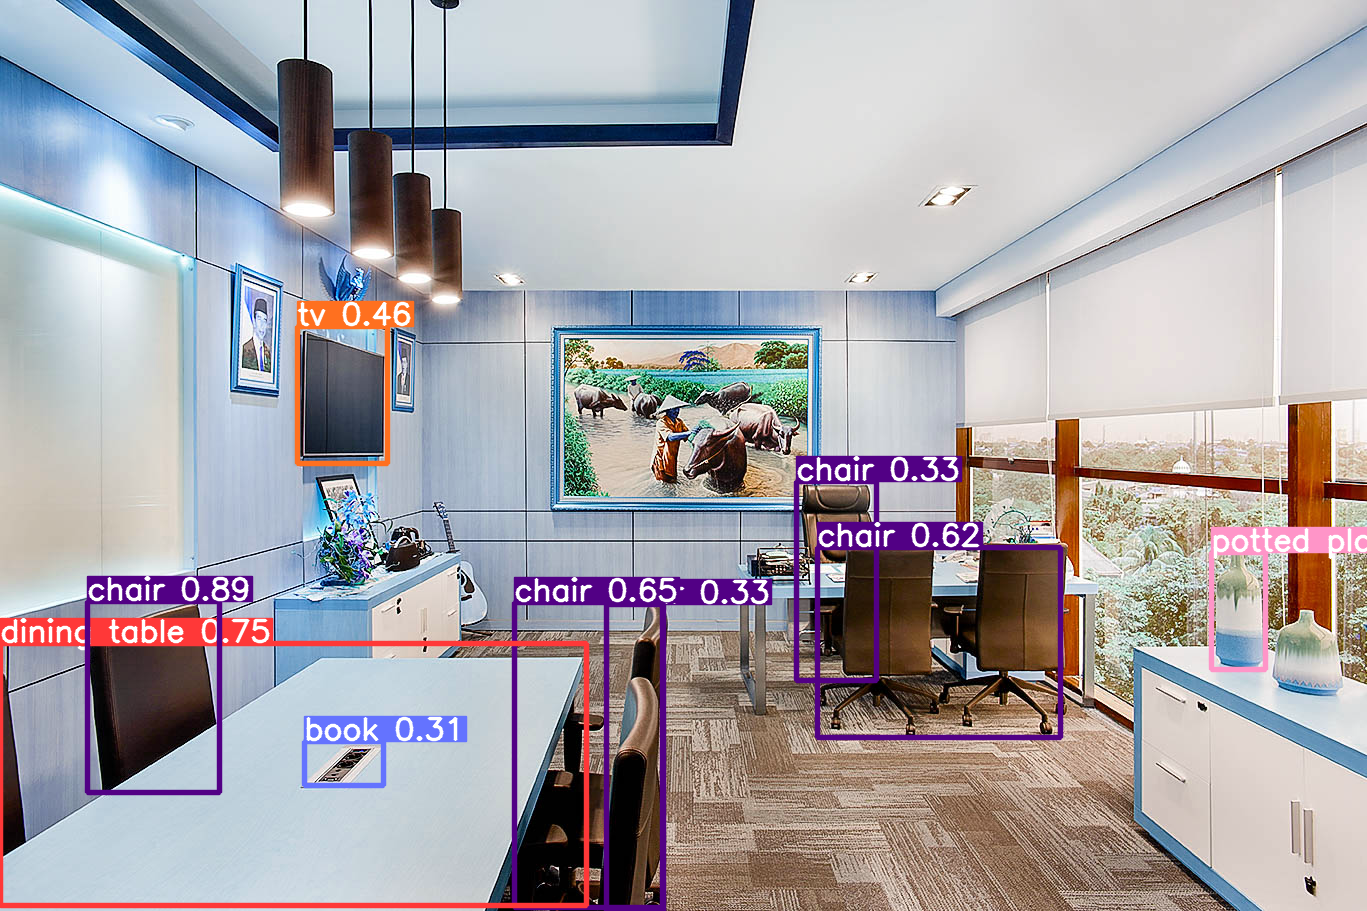

Saved 1 image to runs/detect/exp3


In [ ]:
import torch
import cv2
from google.colab import files

# Upload file gambar
uploaded = files.upload()

# Fungsi untuk deteksi objek pada gambar
def detect_image(image_file):
    # Membaca gambar menggunakan OpenCV
    img = cv2.imread(image_file)

    # Deteksi objek menggunakan YOLOv5
    results = model(img)

    # Menampilkan hasil deteksi
    results.show()

    # Menyimpan hasil deteksi
    results.save()  # Hasil deteksi akan disimpan di folder 'runs/detect/exp'

# Mendapatkan nama file gambar yang diupload
image_file = next(iter(uploaded))

# Deteksi objek pada gambar
detect_image(image_file)


In [ ]:
# Menyimpan hasil deteksi gambar
results.save(save_dir='/content/detected_images')  # Folder untuk menyimpan hasil deteksi gambar

Saved 1 image to /content/detected_images2


In [ ]:
import torch
import cv2
from google.colab import files
import shutil
import os

# Upload file video
uploaded = files.upload()

# Fungsi untuk deteksi objek pada video
def detect_video(video_file):
    # Membaca video menggunakan OpenCV
    cap = cv2.VideoCapture(video_file)

    # Mendapatkan informasi dari video input
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Menyimpan output video dengan hasil deteksi
    output_file = '/content/output_video.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Menggunakan codec yang umum untuk MP4
    out = cv2.VideoWriter(output_file, fourcc, 30.0, (frame_width, frame_height))  # Menyesuaikan resolusi

    # Membaca frame demi frame dan melakukan deteksi objek
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Deteksi objek pada setiap frame
        results = model(frame)

        # Menyimpan frame dengan bounding boxes ke video output
        result_frame = results.render()[0]  # Mendapatkan frame dengan bounding box
        out.write(result_frame)  # Menulis frame yang sudah diberi bounding box

    # Menutup video setelah deteksi selesai
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print("Proses deteksi selesai. Video telah diproses.")

    # Mengunduh video hasil deteksi
    shutil.move(output_file, '/content/output_video.mp4')
    files.download('/content/output_video.mp4')  # Mengunduh video

# Mendapatkan nama file video yang diupload
video_file = next(iter(uploaded))

# Deteksi objek pada video
detect_video(video_file)


Saving macet.mp4 to macet.mp4


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

Proses deteksi selesai. Video telah diproses.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>